# Тема: Определение хаба для статьи на сайте Хабр
## Этап: подготовка данных
### В данном ноутбуке я обработаю 20000 статей Хабра, выделю слова, лемматизирую из и посчитаю, сколько раз встретится каждое слово в этих статьях. Попробую определить, как растёт количество уникальных слов в зависимости от роста количества обработанных слов. А также попробую понять, слова с какой частотой стоит убирать и на каком этапе

In [146]:
import pickle
import pandas as pd
import re
import numpy as np
from matplotlib import pyplot as plt
import warnings

warnings.filterwarnings('ignore')

In [148]:
#ссылочки
PATH = 'datasets/'
PATH_ARTICLES = PATH + 'articles.pkl'
PATH_ID_OF_LAST_ARTICLE_COUNTED = PATH + 'id_of_last_article_counted.txt'
PATH_FREQUENCY_OF_WORDS_CLEAN = PATH + 'frequency_of_words_clean.pkl'
PATH_FREQUENCY_OF_WORDS_MINUS_1 = PATH + 'frequency_of_words_minus_1.pkl'
PATH_FREQUENCY_OF_WORDS_MINUS_2 = PATH + 'frequency_of_words_minus_2.pkl'
PATH_COORDS_FOR_PLOT_CLEAN = PATH + "coords_clean.pkl"
PATH_COORDS_FOR_PLOT_MINUS_1 = PATH + "coords_minus_1.pkl"
PATH_COORDS_FOR_PLOT_MINUS_2 = PATH + "coords_minus_2.pkl"

## 1) Функция для лемматизации слов в статье. Получает текст статьи и возвращает список с лемматизированными словами

In [179]:
#Pymorphy2 для лемматизации
from pymorphy2 import MorphAnalyzer
#nltk.corpus для списка стоп-слов, которые мы будем удалять
from nltk.corpus import stopwords

#Шаблон для удаления всего лишнего
pattern =  r"[^а-яa-z_'\-]"
stopwords_ru = stopwords.words("russian")
morph = MorphAnalyzer()

#Функция лемматизации - принимает на вход статью str, возвращает список лемматизированных слов из статьи
def lemmatize(doc):
    doc = doc.lower()
    #Уменьшаем регистр, убираем пробельные символы, заменяем всё, кроме букв и символов _,-,' на пробелы 
    doc = re.sub(pattern, ' ', doc.strip())
    #Разбиваем текст по словам
    doc = doc.split()
    tokens = []
    for token in doc:
        #Убираем стоп-слова и слишком короткие слова
        if token and token not in stopwords_ru and len(token)>2:
            #Лемматизируем каждое слово
            token = morph.normal_forms(token)[0]
            tokens.append(token)
    return tokens

## 2) Считаем частоту слов во всех статьях, предварительно лемматизируя их

In [182]:
#Берём статьи из файла
with open(PATH_ARTICLES, 'rb') as file:
    articles = pd.DataFrame(pickle.load(file))

try:
    #Проверяем, обработаны ли уже какие-то статьи
    with open(PATH_ID_OF_LAST_ARTICLE_COUNTED, 'r') as file:
        CURRENT_ARTICLE_ID = int(file.read())
    with open(PATH_FREQUENCY_OF_WORDS_CLEAN, 'rb') as file:
            words_freq = dict(pickle.load(file))
except:
    #Если нет, то начинаем с первой статьи и создаём пустой словарь
    CURRENT_ARTICLE_ID = 0
    words_freq = dict()

#Здесь будут храниться координаты для графика x=кол-во обработанных слов, y=кол-во уникальных слов
coords = []
#Подсчёт кол-ва обработанных слов
word_count = 0

for i, text in enumerate(articles['text'][CURRENT_ARTICLE_ID:]):
    #Из текста статьи делаем список лемматизированных слов
    words_from_article = lemmatize(text)
    #Если функция lemmatize вернула какие-то слова
    if words_from_article:
        for word in words_from_article:
            word_count += 1
            if word in words_freq:
                words_freq[word] += 1
            else:
                words_freq[word] = 1
        CURRENT_ARTICLE_ID += 1

    if i!=0 and i%100 == 0 or i==len(articles['text'][CURRENT_ARTICLE_ID:])-1:
        #опционально - убираем все слова частоты k и ниже каждые 100 статей
        """k=1
        words_freq = {key : value for key, value in words_freq.items() if value > k}"""
        #сохраняем id текущей статьи
        with open(PATH_ID_OF_LAST_ARTICLE_COUNTED, 'w') as file:
            file.write(str(CURRENT_ARTICLE_ID))
        #Сохраняем текущий словарь с частотой слов
        with open(PATH_FREQUENCY_OF_WORDS_TEMPORARY, 'wb') as file:
            file.write(pickle.dumps(words_freq))
        #Сохраняем координаты
        coords.append((word_count, len(words_freq)))
        with open(PATH_COORDS_FOR_PLOT, 'wb') as file:
            file.write(pickle.dumps(coords))
        print(i, CURRENT_ARTICLE_ID-1, len(words_freq))

## 3) Читаем из файлов полученные данные

In [162]:
#Словарь вида "слово" : "сколько раз это слово встретилось"
with open(PATH_FREQUENCY_OF_WORDS_CLEAN, 'rb') as file:
    freq_clean = dict(pickle.load(file))
    
#Такой же словарь, как freq_clean, только каждые 100 статей мы убирали все слова, которые встретились только 1 раз
#Нужно для сравнения, насколько медленнее будет расти кол-во уникальных слов по сравнению с freq_clean
with open(PATH_FREQUENCY_OF_WORDS_MINUS_1, 'rb') as file:
    freq_minus_1 = dict(pickle.load(file))
    
#Координаты для графика зависимости "кол-во уникальных слов" от "общего кол-ва обработанных слов" 
with open(PATH_COORDS_FOR_PLOT_CLEAN, 'rb') as file:
    coords_clean = list(pickle.load(file))
    
#Координаты для графика зависимости "кол-во уникальных слов" от "общего кол-ва обработанных слов",
#если каждые 100 статей убирать слова с частотой 1
with open(PATH_COORDS_FOR_PLOT_MINUS_1, 'rb') as file:
    coords_minus_1 = list(pickle.load(file))

#Координаты для графика зависимости "кол-во уникальных слов" от "общего кол-ва обработанных слов",
#если каждые 100 статей убирать слова с частотой 2
with open(PATH_COORDS_FOR_PLOT_MINUS_2, 'rb') as file:
    coords_minus_2 = list(pickle.load(file))

#Из списка из кортежей (x, y) получаем списки отдельно по х и по у
y_coord_clean = np.array([x[1] for x in coords_clean])
x_coord_clean = np.array([x[0] for x in coords_clean])

y_coord_minus_1 = np.array([x[1] for x in coords_minus_1])
x_coord_minus_1 = np.array([x[0] for x in coords_minus_1])

y_coord_minus_2 = np.array([x[1] for x in coords_minus_2])
x_coord_minus_2 = np.array([x[0] for x in coords_minus_2])

## 4) Вывод полученной информации и графики

### Дополнительно я рассмотрю, как растёт количество уникальных слов, если каждые 100 статей убирать все слова с частотой 1/с частотой 1-2. Пока вариант убрать все слова с частотой 1-10 уже после обработки всех статей выглядит более точным, но я рассмотрю эти варианты, чтобы сравнить скорость роста

График зависимости количества уникальных слов от количества всех обработанных слов:


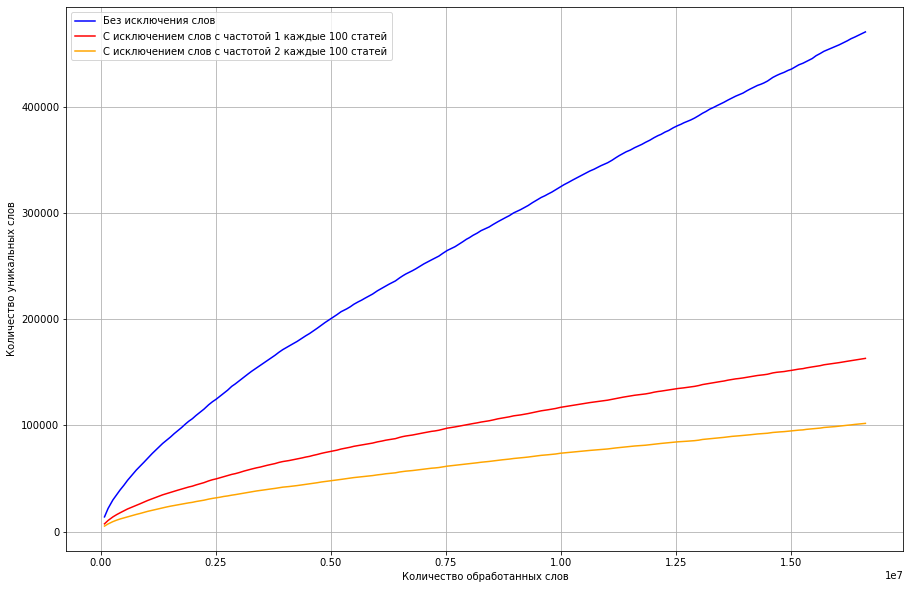




График зависимости процента уникальных слов от количества всех обработанных слов


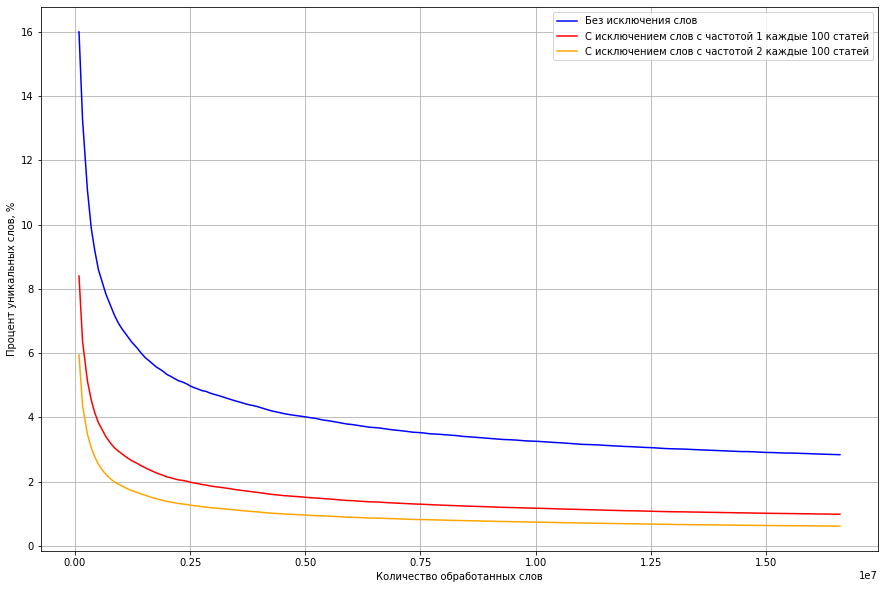

In [166]:
#График с абсолютными значениями
print('График зависимости количества уникальных слов от количества всех обработанных слов:')
plt.figure(figsize = (15, 10))
plt.plot(x_coord_clean, y_coord_clean, color='blue', label='Без исключения слов')
plt.plot(x_coord_minus_1, y_coord_minus_1, color='red', label='С исключением слов с частотой 1 каждые 100 статей')
plt.plot(x_coord_minus_2, y_coord_minus_2, color='orange', label='С исключением слов с частотой 2 каждые 100 статей')
plt.xlabel('Количество обработанных слов')
plt.ylabel('Количество уникальных слов')
plt.grid(True)
plt.legend()
plt.show()

#График с процентом уникальных слов
print('\n\n\nГрафик зависимости процента уникальных слов от количества всех обработанных слов')
plt.figure(figsize = (15, 10))
plt.plot(x_coord_clean, y_coord_clean/x_coord_clean*100, color='blue', label='Без исключения слов')
plt.plot(x_coord_minus_1, y_coord_minus_1/x_coord_minus_1*100, color='red', 
         label='С исключением слов с частотой 1 каждые 100 статей')
plt.plot(x_coord_minus_2, y_coord_minus_2/x_coord_minus_2*100, color='orange', 
         label='С исключением слов с частотой 2 каждые 100 статей')
plt.xlabel('Количество обработанных слов')
plt.ylabel('Процент уникальных слов, %')
plt.grid(True)
plt.legend()
plt.show()

## Заметно, что слова с частотой 1 занимают очень большой процент от общего количества слов.

## 5)  Уберём из общего количества уникальных слов все слова с частотой один, от 1 до 2, от 1 до 5, от 1 до 10 и посмотрим на сколько уникальных элементов станет меньше в каждом случае

In [167]:
print()
freq_clean_but_minus_1 = {key:value for key, value in freq_clean.items() if value >1}
freq_clean_but_minus_2 = {key:value for key, value in freq_clean_but_minus_1.items() if value >2}
freq_clean_but_minus_5 = {key:value for key, value in freq_clean_but_minus_2.items() if value >5}
freq_clean_but_minus_10 = {key:value for key, value in freq_clean_but_minus_2.items() if value >10}
print('Количество уникальных слов, если от всех уникальных убрать слова:\n')
print('Не убирать', '-'*15, len(freq_clean))
print('C частотой 1', '-'*13, len(freq_clean_but_minus_1))
print('C частотой от 1 до 2', '-'*5, len(freq_clean_but_minus_2))
print('C частотой от 1 до 5', '-'*5, len(freq_clean_but_minus_5))
print('C частотой от 1 до 10', '-'*4, len(freq_clean_but_minus_10))
print()


Количество уникальных слов, если от всех уникальных убрать слова:

Не убирать --------------- 471107
C частотой 1 ------------- 205697
C частотой от 1 до 2 ----- 144545
C частотой от 1 до 5 ----- 84306
C частотой от 1 до 10 ---- 54146



### Видно, что мы можем уменьшить список уникальных слов больше, чем в два раза, если после обработки убрать все слова с частотой 1. 
### Вероятно, что без вреда для результата можно убрать все слова с частотой 5 и меньше. Тогда количество уникальных слов сократится больше, чем в пять раз
### Также возможно, без вреда для результата можно убрать все слова с частотой 10 и меньше, тогда количество уникальных слов станет почти в 10 раз меньше
### Удостовериться, до какой частоты нужно убирать слова, и чтобы при этом не падала эффективность программы, можно будет проверяя разные варианты при обучении

# 6) Построим таблицу с распределением слов по частоте от 1 до 10

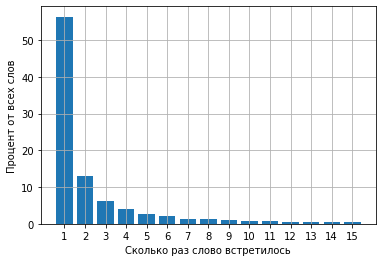

In [169]:
#Создадим словарь "частота встречаемости слова" : "количество слов с такой частотой"
word_freq_list_clean = dict()
for key, value in freq_clean.items():
    if value in word_freq_list_clean:
        word_freq_list_clean[value] += 1
    else:
        word_freq_list_clean[value] = 1

sorted_counts = sorted(word_freq_list, reverse=False)
coords = [(key, word_freq_list[key]) for key in sorted_counts]
y_coords = [x[1]*100/len(freq) for x in coords[:15]]
x_coords = [x[0] for x in coords[:15]]
plt.bar(x_coords, y_coords)
plt.xticks(np.arange(1, 16))
plt.xlabel("Сколько раз слово встретилось")
plt.ylabel("Процент от всех слов")
plt.grid(True)
plt.show()

### Видно, что ощутимая масса от всех слов это частоты от 1 до 5

## Остаётся ещё исключить слова, которые встречаются очень часто, но при этом не помогают определить тему(хаб) статьи. Но это уже имеет смысл делать, когда мы определимся с алгоритмом и технологиями определения хаба статьи, и сможем тестировать разные варианты